In [122]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np 
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import functools as ft
import statsmodels as sm
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2019-09-01', end='2022-11-01').to_pydatetime()
# https://www.caiso.com/Documents/Section39-MarketPowerMitigationProcedures-asof-Nov1-2021.pdf 
# minimum power bid is at -150$
# maximum power bid is at 2000$ 
# http://www.caiso.com/documents/presentation-ferc-order-831-import-bidding-market-parameters-training-apr-28-2021.pdf
def weekends(start, end):
    df = pd.DataFrame({'Dates': pd.date_range(start, end)})
    business_dates = pd.bdate_range(start, end)
    answer = df.loc[~df['Dates'].isin(business_dates)]
    return answer

weekends = weekends(start='2019-09-01', end='2022-11-01')['Dates'].dt.to_pydatetime()
holidays = np.concatenate((holidays, weekends))

In [123]:
'''
Note: according to http://www.caiso.com/InitiativeDocuments/Presentation-Day-AheadMarketOverview-Nov30-2021.pdf, 
DAM bids are closed at 10am prior to the trade day of the next day, but open as far as 8 days before the trade date
DAM clearing results are announced at 1pm  

Trading hub and associated tac areas: 
# SP15 -> TAC_ECNTR, TAC_NCNTR, TAC_SOUTH
# ZP26 -> TAC_NORTH
# NP15 -> TAC_NORTH 
'''
lmps = pd.read_csv('data/dam_lmps.csv', index_col=0).set_index('OPR_DT')
load_fcst = pd.read_csv('data/load_fcst.csv', index_col=0).set_index('OPR_DT')
ren_fcst = pd.read_csv('data/ren_fcst.csv', index_col=0).set_index('OPR_DT')
gas = pd.read_csv('data/gas_flow.csv', index_col=0).set_index('OPR_DT')
ghg = pd.read_csv('data/ghg.csv', index_col=0).set_index('OPR_DT')
external = pd.read_csv('data/import_export_data.csv', index_col=0).set_index('OPR_DT')

In [124]:
# load forecasts for entire SP15 TAC areas
load_fcst = load_fcst.loc[load_fcst['TAC_AREA_NAME'] == 'CA ISO-TAC'][['OPR_HR','MW']].rename({'MW':'LOAD'}, axis=1)
# renewable forecasts by trading hub and type (wind/solar)
ren_fcst = ren_fcst[['OPR_HR','TRADING_HUB','RENEWABLE_TYPE','MW']]

solar = ren_fcst[ren_fcst['RENEWABLE_TYPE'] == 'Solar'].rename({'MW':'SOLAR'}, axis=1)
wind = ren_fcst[ren_fcst['RENEWABLE_TYPE'] == 'Wind'].rename({'MW':'WIND'}, axis=1)
imports = external[((external['TAC_ZONE_NAME'] == 'TAC_ECNTR') | (external['TAC_ZONE_NAME'] == 'TAC_NCNTR') | (external['TAC_ZONE_NAME'] == 'TAC_SOUTH')) & (external['SCHEDULE'] == 'Import')]
exports = external[((external['TAC_ZONE_NAME'] == 'TAC_ECNTR') | (external['TAC_ZONE_NAME'] == 'TAC_NCNTR') | (external['TAC_ZONE_NAME'] == 'TAC_SOUTH')) & (external['SCHEDULE'] == 'Export')]
generation = external[((external['TAC_ZONE_NAME'] == 'TAC_ECNTR') | (external['TAC_ZONE_NAME'] == 'TAC_NCNTR') | (external['TAC_ZONE_NAME'] == 'TAC_SOUTH')) & (external['SCHEDULE'] == 'Generation')]

In [125]:
# get sum of TAC ZONE generation which is the trading hub total generation
generation = generation[['OPR_HR', 'MW']].groupby([generation.index, 'OPR_HR']).sum().reset_index().set_index('OPR_DT')
imports = imports[['OPR_HR', 'MW']].groupby([imports.index, 'OPR_HR']).sum().reset_index().set_index('OPR_DT')
exports = exports[['OPR_HR', 'MW']].groupby([exports.index, 'OPR_HR']).sum().reset_index().set_index('OPR_DT')

In [126]:
generation

,OPR_HR,MW
OPR_DT,,
2019-09-01,1,6396.65
2019-09-01,2,6252.65
2019-09-01,3,5994.43
2019-09-01,4,5745.90
2019-09-01,5,5604.56
...,...,...
2022-11-01,20,10183.35
2022-11-01,21,9963.35
2022-11-01,22,9428.84


In [127]:
ghg['GHG_PRC_IDX_prev'] = ghg['GHG_PRC_IDX'].shift(1)
imports['IMP_MW_prev'] = imports['MW'].shift(24)
exports['EXP_MW_prev'] = exports['MW'].shift(24)
generation['GEN_MW_prev'] = generation['MW'].shift(24)
gas['GAS_AVG_PRC_prev'] = gas['GAS_AVG_PRC'].shift(24)
imports.rename({'MW':'IMP_MW'}, axis=1, inplace=True)
exports.rename({'MW':'EXP_MW'}, axis=1, inplace=True)
generation.rename({'MW':'GEN_MW'}, axis=1, inplace=True)

In [128]:
imports = imports[['OPR_HR', 'IMP_MW_prev', 'IMP_MW']]
exports = exports[['OPR_HR', 'EXP_MW_prev', 'EXP_MW']]
generation = generation[['OPR_HR', 'GEN_MW_prev', 'GEN_MW']]
ghg = ghg[['GHG_PRC_IDX_prev', 'GHG_PRC_IDX']]

In [89]:
'''
NP-15 data
# get lmps from specific trading hub
np15_lmps = lmps[lmps['THUB'] == 'TH_NP15_GEN-APND']
np15_lmps['LMP_prev'] = np15_lmps['LMP'].shift(24)
np15_lmps = np15_lmps.join(ghg, on='OPR_DT')
# get the solar/wind forecast for trading hub
np15_solar = solar[solar['TRADING_HUB'] == 'NP15'][['OPR_HR', 'SOLAR']]
np15_wind = wind[wind['TRADING_HUB'] == 'NP15'][['OPR_HR', 'WIND']]
np15 = [np15_lmps, load_fcst, np15_solar, np15_wind, gas, imports, exports]
np15_data = ft.reduce(lambda left, right: pd.merge(left, right, on=['OPR_DT','OPR_HR']), np15)

# assign boolean value to indicate whether the date is a holiday or not 
np15_data['HOL'] = list(map(lambda x: 1 if (datetime.datetime.strptime(x,'%Y-%m-%d') in holidays) else 0, np15_data.index))
np15_data.to_csv('data/np15.csv')
'''

/var/folders/sv/bkryq0q934v59v1kgd68dtxw0000gn/T/ipykernel_97945/3830914622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np15_lmps['LMP_prev'] = np15_lmps['LMP'].shift(24)


In [129]:
# get lmps from specific trading hub
sp15_lmps = lmps[lmps['THUB'] == 'TH_SP15_GEN-APND']
sp15_lmps['LMP_prev'] = sp15_lmps['LMP'].shift(24)
sp15_lmps['LMP_prev7'] = sp15_lmps['LMP'].shift(24*7)
sp15_lmps['LMP_prev14'] = sp15_lmps['LMP'].shift(24*14)
sp15_lmps['LMP_prev21'] = sp15_lmps['LMP'].shift(24*21)

sp15_lmps = sp15_lmps.join(ghg, on='OPR_DT')
# get the solar/wind forecast for trading hub
sp15_solar = solar[solar['TRADING_HUB'] == 'SP15'][['OPR_HR', 'SOLAR']]
sp15_wind = wind[wind['TRADING_HUB'] == 'SP15'][['OPR_HR', 'WIND']]
sp15 = [sp15_lmps, load_fcst, sp15_solar, sp15_wind, gas, imports, exports, generation]
sp15_data = ft.reduce(lambda left, right: pd.merge(left, right, on=['OPR_DT','OPR_HR']), sp15)

# assign boolean value to indicate whether the date is a holiday or not 
sp15_data['HOL'] = list(map(lambda x: 1 if (datetime.datetime.strptime(x,'%Y-%m-%d') in holidays) else 0, sp15_data.index))
sp15_data.to_csv('data/sp15.csv')

/var/folders/sv/bkryq0q934v59v1kgd68dtxw0000gn/T/ipykernel_34289/2735404580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp15_lmps['LMP_prev'] = sp15_lmps['LMP'].shift(24)
/var/folders/sv/bkryq0q934v59v1kgd68dtxw0000gn/T/ipykernel_34289/2735404580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp15_lmps['LMP_prev7'] = sp15_lmps['LMP'].shift(24*7)
/var/folders/sv/bkryq0q934v59v1kgd68dtxw0000gn/T/ipykernel_34289/2735404580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [130]:
sp15_data.columns

Index(['THUB', 'OPR_HR', 'LMP', 'LMP_prev', 'LMP_prev7', 'LMP_prev14',
       'LMP_prev21', 'GHG_PRC_IDX_prev', 'GHG_PRC_IDX', 'LOAD', 'SOLAR',
       'WIND', 'GAS_AVG_PRC', 'GAS_AVG_PRC_prev', 'IMP_MW_prev', 'IMP_MW',
       'EXP_MW_prev', 'EXP_MW', 'GEN_MW_prev', 'GEN_MW', 'HOL'],
      dtype='object')

/Users/richardz/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

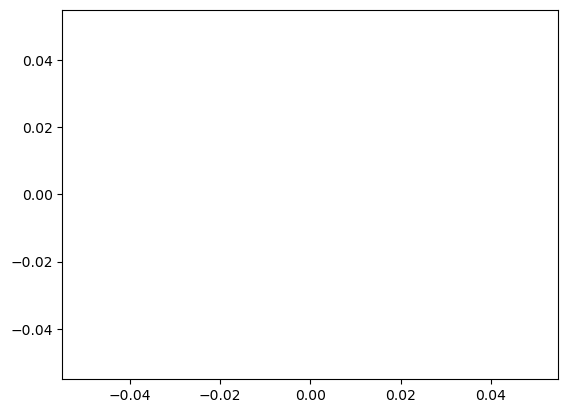

In [136]:
sns.lineplot(sp15_data['LMP'])

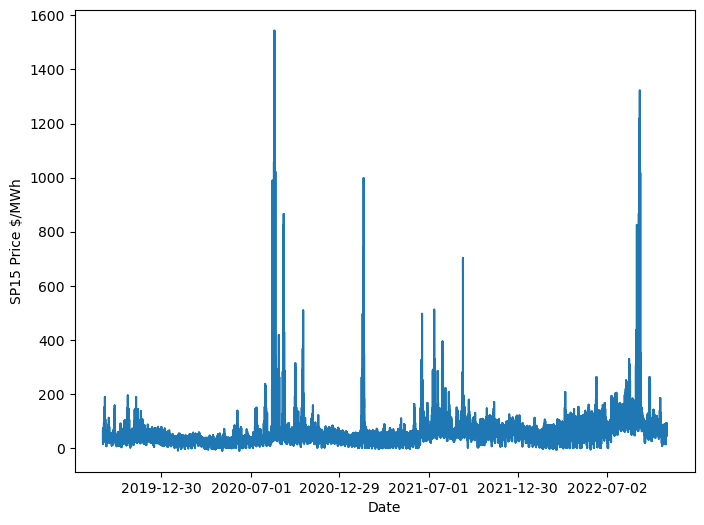

In [152]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(8, 6))
view = sp15_data
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator)
ax.plot(view.index, view['LMP']);
plt.ylabel('SP15 Price $/MWh')
plt.xlabel('Date')
plt.savefig('sp15_lmp.png')

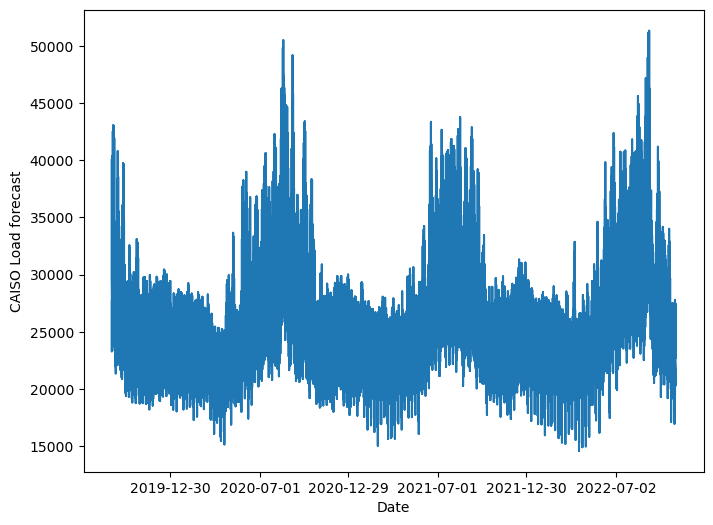

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))
view = sp15_data
half_year_locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(half_year_locator)
ax.plot(view.index, view['LOAD']);
plt.ylabel('CAISO Load forecast')
plt.xlabel('Date')
plt.savefig('sp15_load.png')